# Modulação e Demodulação FSK para Comunicação via Ondas Acústicas

## Motivação

 - Ainda que de baixa capacidade, é uma forma de comunicação alternativa à comunicação sem fio via onda eletromagnética, comumente empregadano cotidiano, como telefonia móvel, redes WiFi, dentre outras.
 - É utilizada em ambientes subaquáticos para monitoramento de diferentes áreas, visto que ondas de rádio frequência sofrem altas atenuações a baixas distâncias
 - A modulação de áudio FSK, já utilizada para comunicação subaquática, é bem simples de implementar, e permite testes em ambientes atmosféricos, visto que não é possível (ainda) realizar testes subaquáticos.


## Objetivos

Implementar um processo de comunicação, envolvendo codificação de mensagens, modulação e demodulação de sinais via software através de ondas sonoras moduladas por chaveamento de frequência. Além disso, discutir aspectos da comunicação, bem como suas viabilidade, eficácia e limitações, a partir de testes em ambientes acústicos em que o ar é o meio comunicante.

## Metodologia

Quatro passos:
 - Codificação
 - Modulação
 - Demodulação
 - Decodificação
Verificação por taxa de erro de bit (_BER_)

In [16]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append("../")
sys.path.append("../src/")

from modulation import *
from demodulation import *

## Codificação

Consiste em transformar uma mensagem em um vetor de bits.
À mensagem são adicionados cabeçalho e cauda que serão sincronizados posteriormente


In [10]:
sync = sincronizeMessage("Hello World!")
print(sync)
bits = stringToBits(sync)
print(bits)

2wLQTcNgiXyP<{Hello World!}>ggIVZMbi09VM
[0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1
 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0
 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0
 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1]


## Modulação

Modular a mensagem seguindo a equação:

<p align="center">
    <a href="https://www.codecogs.com/eqnedit.php?latex=x(t)&space;=&space;A_0cos(2\pi\&space;(f_0&space;&plus;&space;\Delta_f&space;\cdot&space;m_b(t))\&space;t)&space;%0" target="_blank"><img src="https://latex.codecogs.com/gif.latex?x(t)&space;=&space;A_0cos(2\pi\&space;(f_0&space;&plus;&space;\Delta_f&space;\cdot&space;m_b(t))\&space;t)&space;%0" title="x(t) = A_0cos(2\pi\ (f_0 + \Delta_f \cdot m_b(t))\ t) %0" /></a>
</p>


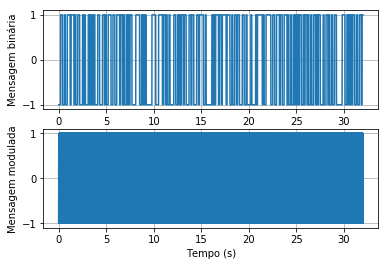

In [11]:
mb = bitsToWave(bits,baud=10)
t, x = FSKMod(mb)

## Plotting Data ##
ax_bit = plt.subplot(211)
ax_bit.plot(t, mb)
ax_bit.set_ylabel('Mensagem binária')
ax_bit.grid(True)


ax_mod = plt.subplot(212)
ax_mod.plot(t, x)
ax_mod.set_ylabel('Mensagem modulada')
ax_mod.set_xlabel('Tempo (s)')
ax_mod.grid(True)
plt.show()


## Demodulação

Processo não-coerente, isto é, não depende da fase para ser feito. O processo pode ser sintetizado pela figura (INSERIR FIGURA DEPOIS):


In [17]:
audio = getAudio()
bitwave = FSKdemod(audio)

Start recording..
Record ended


### Subamostragem

Deve seguir a taxa de bits da comunicação, pois leva em conta o _número de amostras por bit_ para fazer uma média.


In [14]:
bits = bitWaveSample(bitwave)

NameError: name 'bitwave' is not defined

## Decodificação

Consiste no processo de sincronização e obtenção da mensagem a partir de um vetor de bits.

NameError: name 'INIT_STREAM' is not defined

## Testes e Resultados

## Considerações Finais

(VAMOS VER O QUE ESCREVER AQUI POSTERIORMENTE. IMAGINO ALGO SIMPLES, RELACIONADO À MEDIÇÃO DE _BER_ OU ALGO ASSIM)